In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import wget

In [2]:
# download data
if not os.path.exists('prediction-challenge-01-data.npz'):
    url = 'https://git.imp.fu-berlin.de/yuxuac94/'\
    'deep-learning-examples/-/raw/master/01-Basic/'\
    'prediction-challenge-01-data.npz'
    wget.download(url, './prediction-challenge-01-data.npz')

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)
print(test_x.shape, test_x.dtype)

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


In [3]:
# split the data into train and valid set: 16000 vs. 4000
train_size = 18000
train_x, val_x = data_x[:train_size, ], data_x[train_size:, ]
train_y, val_y = data_y[:train_size, ], data_y[train_size:, ]

In [4]:
# hyper-parameters
input_size = 784
num_classes = 10
num_epochs = 200
batch_size = 256
learning_rate = 0.005
weight_decay = 0.005

# set device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [5]:
 # create datasloader
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_loader = train_loader.shuffle(
    buffer_size=train_x.shape[0], 
    reshuffle_each_iteration=True
).batch(batch_size)

In [6]:
# build a logistic regressor in a naive way
class LogisticRegressor(keras.Model):
    def __init__(self, input_size, output_size, weight_decay=0):
        super(LogisticRegressor, self).__init__()
        # for weight initialization, use Xavier rule
        self.initializer = tf.initializers.GlorotUniform()
        self.W = tf.Variable(
            self.initializer((input_size, num_classes)), 
            name='weight')
        self.b = tf.Variable(tf.zeros([num_classes]), name='bias')
        self.weight_decay = weight_decay
        self.flatten = layers.Flatten()

    def call(self, x):
        out = self.flatten(x)
        out = tf.matmul(out, self.W) + self.b
        return out

    # get L2 regularization loss
    def l2_loss(self):
        return self.weight_decay * \
            (tf.nn.l2_loss(self.W) + tf.nn.l2_loss(self.b))

In [7]:
 # compute loss for a batch
def cross_entropy_loss(outputs, labels):
    labels = tf.cast(labels, tf.int64)
    # prediction loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=labels, logits=outputs)
    return tf.reduce_mean(loss)


def accuracy(outputs, labels):
    hit = tf.equal(tf.argmax(outputs, 1), 
                   tf.cast(labels, tf.int64))
    return tf.reduce_mean(tf.cast(hit, tf.float32), 
                          axis=-1)

In [8]:
# train the model
model = LogisticRegressor(input_size=input_size,
                          output_size=num_classes, 
                          weight_decay=weight_decay)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
best_val_acc = 0

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.numpy(), labels.numpy()

        # wrap computation inside for automatic differentiation
        with tf.GradientTape() as g:
            # forward pass
            outputs = model(images, training=True)
            loss =  cross_entropy_loss(outputs, labels)
            loss += model.l2_loss()
            train_acc = accuracy(outputs, labels)
        
        # backward pass
        grad = g.gradient(loss, [model.W, model.b])
        optimizer.apply_gradients(zip(grad, [model.W, model.b]))

    # each 10 epochs, report training loss 
    # and accuracy for the last batch
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
            epoch + 1, num_epochs, loss.numpy()))
        print('Training Accuracy: {:.3f}%'.format(100 * train_acc))

    # validate after each epoch
    images, labels = val_x, val_y
    outputs = model(images, Training=False)
    val_acc = accuracy(outputs, labels)

    # print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('Validation Accuracy: {:.3f}%'.format(100 * val_acc))
        print('=' * 50)

    # save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        if best_val_acc > 0.9:
            model.save_weights('./saved_model.ckpt', overwrite=True)

print('Best Valid Accuracy: {:.3f}%'.format(100 * best_val_acc))

Epoch [10/200], Training Loss: 27.2189
Training Accuracy: 92.500%
Validation Accuracy: 88.750%
Epoch [20/200], Training Loss: 187.6049
Training Accuracy: 82.500%
Validation Accuracy: 76.250%
Epoch [30/200], Training Loss: 10.4656
Training Accuracy: 96.250%
Validation Accuracy: 89.400%
Epoch [40/200], Training Loss: 14.8867
Training Accuracy: 92.500%
Validation Accuracy: 88.050%
Epoch [50/200], Training Loss: 12.8695
Training Accuracy: 93.750%
Validation Accuracy: 87.850%
Epoch [60/200], Training Loss: 77.6472
Training Accuracy: 83.750%
Validation Accuracy: 80.950%
Epoch [70/200], Training Loss: 12.5243
Training Accuracy: 90.000%
Validation Accuracy: 88.800%
Epoch [80/200], Training Loss: 127.5294
Training Accuracy: 75.000%
Validation Accuracy: 68.000%
Epoch [90/200], Training Loss: 31.6003
Training Accuracy: 90.000%
Validation Accuracy: 86.650%
Epoch [100/200], Training Loss: 15.4550
Training Accuracy: 93.750%
Validation Accuracy: 88.750%
Epoch [110/200], Training Loss: 21.6724
Trainin

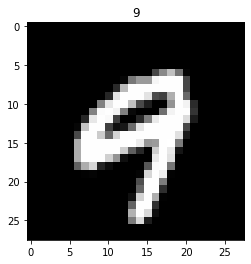

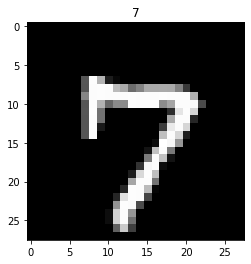

In [9]:
# load the saved model
saved_model = LogisticRegressor(input_size=input_size,
                                output_size=num_classes, 
                                weight_decay=weight_decay)
saved_model.load_weights('./saved_model.ckpt')

# predict on test set with the saved model
outputs = saved_model(test_x, training=False)
test_pred = tf.argmax(outputs, 1).numpy()

# show some answers
for i in range(3):
    plt.imshow(test_x[i].reshape(28, 28), cmap='gray')
    plt.title(test_pred[i])
    plt.show()